In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pid_model as pidmodel
import pid_performances as pidper
import car_model

In [2]:
# Define the constant and initialize the model
eta = 0.1 # damping factor
m_b = 0.01 # mass of the ball
m_c = 500 # mass of the car
g = 9.8 # gravity
r = 1 # radius of the pendulum
model = car_model.Model(eta, m_b,m_c,g,r)

## No-noise simulation of PID controller

In [3]:
noise = np.zeros(300)
# pi: 10,30
# pd: 50,30
# pid: 15,30,30
pid_model = pidmodel.PID(model, 15,30,30)

### Pid controller with $\theta_{ref} = 0.785$ (45°)

overshoot: 0.004
rise time: 7.0
steady state error: 0.0
settling time: 8.0


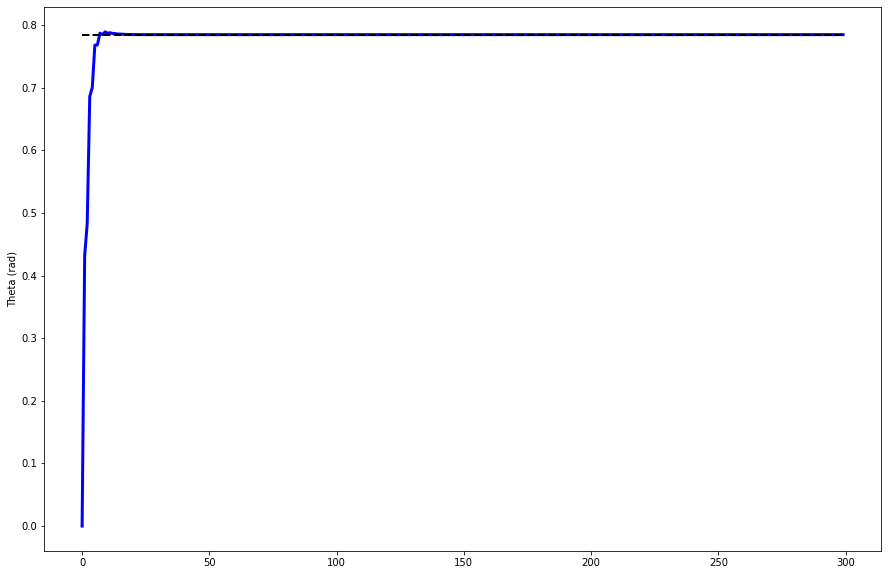

In [4]:
sp = np.zeros(300) + 0.785
theta_store_45, omega_store_45, sp_store_45, v_store_45, u_store_45, ts, theta_noisy_store_45 = pid_model.run(299, 300, sp, [0.0,0.0], noise)
pidper.print_performances(theta_store_45, sp_store_45, ts)
pid_model.plot(theta_store_45, omega_store_45, sp_store_45, v_store_45,u_store_45, ts)

### Pid controller with $\theta_{ref} = 0.262 (15°)$

overshoot: 0.019
rise time: 5.0
steady state error: 0.0
settling time: 15.0


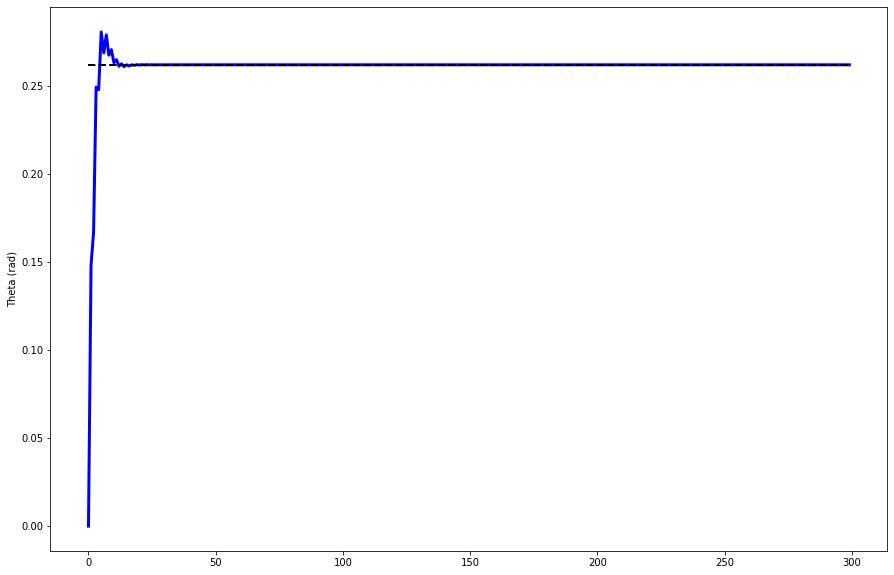

In [5]:
sp = np.zeros(300) + 0.262
theta_store_15, omega_store_15, sp_store_15, v_store_15, u_store_15, ts, theta_noisy_store_15 = pid_model.run(299, 300, sp, [0.0,0.0], noise)
pidper.print_performances(theta_store_15, sp_store_15, ts)
pid_model.plot(theta_store_15, omega_store_15, sp_store_15, v_store_15,u_store_15, ts)

### Average performance considering angles of 15°, 30° and 45°

In [6]:
possible_angle = [0.262, 0.523, 0.785]

overshoot = 0
rise_time = 0
steady_state = 0
settling = 0
for i in range(len(possible_angle)):
    sp = np.zeros(300) + possible_angle[i]
    theta_store, omega_store, sp_store, v_store, u_store, ts, theta_noisy_store = pid_model.run(299, 300, sp, [0.0,0.0], noise)
    overshoot += pidper.overshoot(theta_store, sp_store)
    rise_time += pidper.rise_time(theta_store, sp_store, ts)
    steady_state += pidper.steady_state_error(theta_store, sp_store)
    settling += pidper.settling_time(theta_store, ts)

print(f'mean overshoot: {overshoot/len(possible_angle)}')
print(f'mean rise time: {rise_time/len(possible_angle)}')
print(f'mean steady state error: {steady_state/len(possible_angle)}')
print(f'mean settling time: {settling/len(possible_angle)}')



mean overshoot: 0.015
mean rise time: 5.666666666666667
mean steady state error: 0.0
mean settling time: 12.333333333333334


## Requirements in STL with Moonlight

In [7]:
from moonlight import *

script_oscillation = """
signal {real x;}
domain minmax;
formula oscillation = globally [20.0, 300.0] (x < 0.05);
"""

script_distanceref = """
signal {real d;}
domain minmax;
formula distance = globally [20.0, 300.0] (d < 0.05);
"""

script_max_angle = """
signal {real t; real m; }
domain minmax;
formula max_angle = globally ( t < m );
"""

script_acceleration = """
signal { real x; real y; real u;}
domain minmax; 
formula positive_delta = globally ((x < y) -> (u > 0.0));
formula negative_delta = globally ((x > y) -> (u < 0.0));
"""



moonlightScript_oscillation = ScriptLoader.loadFromText(script_oscillation)
monitor_1 = moonlightScript_oscillation.getMonitor("oscillation")
moonlightScript_distanceref = ScriptLoader.loadFromText(script_distanceref)
monitor_2 = moonlightScript_distanceref.getMonitor("distance")
moonlightScript_max_angle = ScriptLoader.loadFromText(script_max_angle)
monitor_3 = moonlightScript_max_angle.getMonitor("max_angle")
moonlightScript_acceleration = ScriptLoader.loadFromText(script_acceleration)
monitor_4 = moonlightScript_acceleration.getMonitor("positive_delta")
monitor_5 = moonlightScript_acceleration.getMonitor("negative_delta")

In [8]:
def compute_robustness(ts, theta_store, sp_store):
    ts_temp = list(ts)

    # phi_1
    osc = np.zeros(300)
    for i in range(1, len(osc)):
        osc[i] = np.abs(theta_store[i] - theta_store[i-1])
    signals = list(zip(osc))
    result = monitor_1.monitor(ts_temp,signals)
    arrayresults = np.array(monitor_1.monitor(ts_temp,signals))
    max_1 = arrayresults[:,1].max()
    min_1 = arrayresults[:,1].min()

    # phi_2
    dist = np.abs(theta_store - sp_store)
    signals = list(zip(dist))
    result = monitor_2.monitor(ts_temp,signals)
    arrayresults = np.array(monitor_2.monitor(ts_temp,signals))
    max_2 = arrayresults[:,1].max()
    min_2 = arrayresults[:,1].min()

    # phi_3
    theta_max = sp_store + 0.17
    signals = list(zip(theta_store, theta_max))
    result = monitor_3.monitor(ts_temp,signals)
    arrayresults = np.array(monitor_3.monitor(ts_temp,signals))
    max_3 = arrayresults[:,1].max()
    min_3 = arrayresults[:,1].min()

    return max_1, min_1, max_2, min_2, max_3, min_3

### Requirement $\phi_1$ considering 45° and 15°

In [9]:
max_1, min_1, max_2, min_2, max_3, min_3 = compute_robustness(ts, theta_store_45, sp_store_45)
print(f'max robustness phi_1: {max_1}')
print(f'min robustness phi_1: {min_1}')
print(f'max robustness phi_2: {max_2}')
print(f'min robustness phi_2: {min_2}')
print(f'max robustness phi_3: {max_3}')
print(f'min robustness phi_3: {min_3}')

max robustness phi_1: 0.0499393203749668
min robustness phi_1: 0.0499393203749668
max robustness phi_2: 0.049900080934552074
min robustness phi_2: 0.049900080934552074
max robustness phi_3: 0.16999999998997306
min robustness phi_3: 0.16564160226036317


In [10]:
max_1, min_1, max_2, min_2, max_3, min_3 = compute_robustness(ts, theta_store_15, sp_store_15)
print(f'max robustness phi_1: {max_1}')
print(f'min robustness phi_1: {min_1}')
print(f'max robustness phi_2: {max_2}')
print(f'min robustness phi_2: {min_2}')
print(f'max robustness phi_3: {max_3}')
print(f'min robustness phi_3: {min_3}')

max robustness phi_1: 0.04978615968828827
min robustness phi_1: 0.04978615968828827
max robustness phi_2: 0.04987343924250816
min robustness phi_2: 0.04987343924250816
max robustness phi_3: 0.16999999999287108
min robustness phi_3: 0.15131424226520074


### Average robustness considering angles of 15°, 30°, 45°

In [11]:
possible_angle = [0.262, 0.523, 0.785]

noise = np.zeros(300)

max_1 = 0
min_1 = 0
max_2 = 0
min_2 = 0
max_3 = 0
min_3 = 0
for i in range(len(possible_angle)):
    sp = np.zeros(300) + possible_angle[i]
    theta_store, omega_store, sp_store, v_store, u_store, ts, theta_noisy_store = pid_model.run(299, 300, sp, [0.0,0.0], noise)
    max_1_t, min_1_t, max_2_t, min_2_t, max_3_t, min_3_t = compute_robustness(ts, theta_store, sp_store)
    max_1 += max_1_t
    min_1 += min_1_t
    max_2 += max_2_t
    min_2 += min_2_t
    max_3 += max_3_t
    min_3 += min_3_t

print(f'max robustness phi_1: {round(max_1/len(possible_angle),3)}')
print(f'min robustness phi_1: {round(min_1/len(possible_angle),3)}')
print(f'max robustness phi_2: {round(max_2/len(possible_angle),3)}')
print(f'min robustness phi_2: {round(min_2/len(possible_angle),3)}')
print(f'max robustness phi_3: {round(max_3/len(possible_angle),3)}')
print(f'min robustness phi_3: {round(min_3/len(possible_angle),3)}')

max robustness phi_1: 0.05
min robustness phi_1: 0.05
max robustness phi_2: 0.05
min robustness phi_2: 0.05
max robustness phi_3: 0.17
min robustness phi_3: 0.155


## Simulation and robustness with noise

### small noise values

overshoot: 0.004
rise time: 7.0
steady state error: 0.0
settling time: 8.0


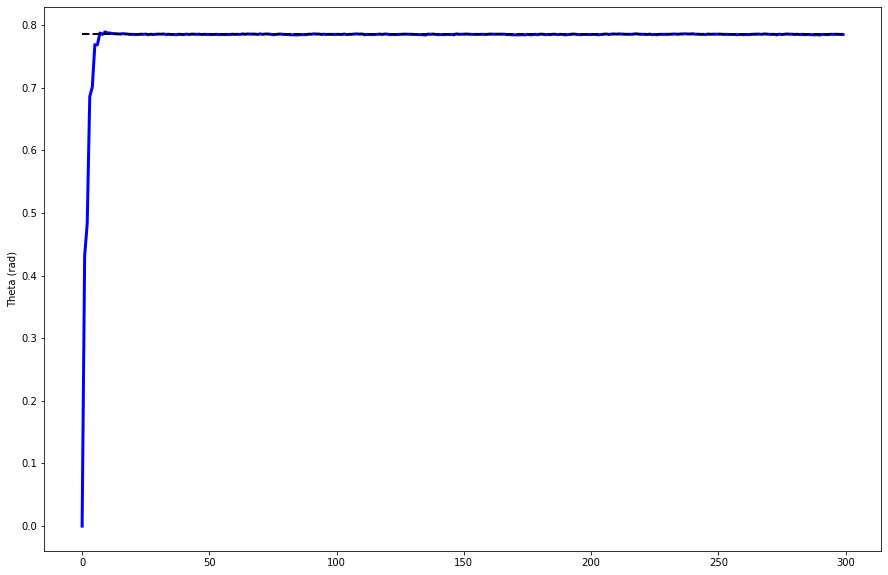

In [12]:
sp = np.zeros(300) + 0.785
noise = np.random.normal(0.0,0.1, 300)*10**(-2)
theta_store, omega_store, sp_store, v_store, u_store, ts, theta_noisy_store = pid_model.run(299, 300, sp, [0.0,0.0], noise)
pidper.print_performances(theta_store, sp_store, ts)
pid_model.plot(theta_store, omega_store, sp_store, v_store,u_store, ts)

In [13]:
max_1, min_1, max_2, min_2, max_3, min_3 = compute_robustness(ts, theta_store, sp_store)
print(f'max robustness phi_1: {round(max_1/len(possible_angle),3)}')
print(f'min robustness phi_1: {round(min_1/len(possible_angle),3)}')
print(f'max robustness phi_2: {round(max_2/len(possible_angle),3)}')
print(f'min robustness phi_2: {round(min_2/len(possible_angle),3)}')
print(f'max robustness phi_3: {round(max_3/len(possible_angle),3)}')
print(f'min robustness phi_3: {round(min_3/len(possible_angle),3)}')

max robustness phi_1: 0.016
min robustness phi_1: 0.016
max robustness phi_2: 0.016
min robustness phi_2: 0.016
max robustness phi_3: 0.057
min robustness phi_3: 0.055


### Average robustness considering the different angles

In [14]:
possible_angle = [0.262, 0.523, 0.785]

noise = np.random.normal(0.0,0.001, 300)

max_1 = 0
min_1 = 0
max_2 = 0
min_2 = 0
max_3 = 0
min_3 = 0
for i in range(len(possible_angle)):
    sp = np.zeros(300) + possible_angle[i]
    theta_store, omega_store, sp_store, v_store, u_store, ts, theta_noisy_store = pid_model.run(299, 300, sp, [0.0,0.0], noise)
    max_1_t, min_1_t, max_2_t, min_2_t, max_3_t, min_3_t = compute_robustness(ts, theta_store, sp_store)
    max_1 += max_1_t
    min_1 += min_1_t
    max_2 += max_2_t
    min_2 += min_2_t
    max_3 += max_3_t
    min_3 += min_3_t

print(f'max robustness phi_1: {round(max_1/len(possible_angle),3)}')
print(f'min robustness phi_1: {round(min_1/len(possible_angle),3)}')
print(f'max robustness phi_2: {round(max_2/len(possible_angle),3)}')
print(f'min robustness phi_2: {round(min_2/len(possible_angle),3)}')
print(f'max robustness phi_3: {round(max_3/len(possible_angle),3)}')
print(f'min robustness phi_3: {round(min_3/len(possible_angle),3)}')
    

max robustness phi_1: 0.048
min robustness phi_1: 0.048
max robustness phi_2: 0.048
min robustness phi_2: 0.048
max robustness phi_3: 0.17
min robustness phi_3: 0.155


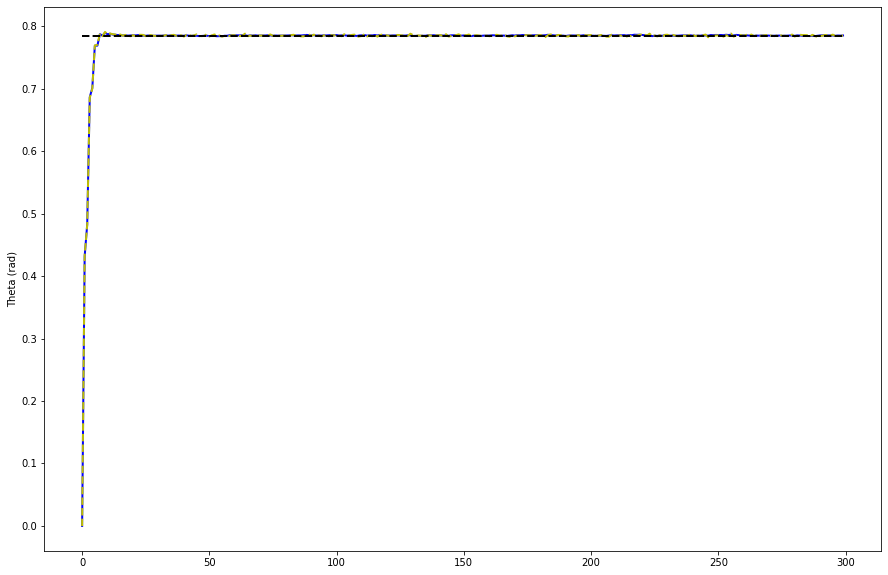

In [15]:
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(ts,theta_store,'b-',linewidth=2)
plt.plot(ts,theta_noisy_store,'y--',linewidth=2)
plt.plot(ts,sp_store,'k--',linewidth=2)
plt.ylabel('Theta (rad)')
plt.show()

In [16]:
possible_angle = [0.262, 0.523, 0.785]

noise = np.random.normal(0.0,0.01, 300)

max_1 = 0
min_1 = 0
max_2 = 0
min_2 = 0
max_3 = 0
min_3 = 0
for i in range(len(possible_angle)):
    sp = np.zeros(300) + possible_angle[i]
    theta_store, omega_store, sp_store, v_store, u_store, ts, theta_noisy_store = pid_model.run(299, 300, sp, [0.0,0.0], noise)
    max_1_t, min_1_t, max_2_t, min_2_t, max_3_t, min_3_t = compute_robustness(ts, theta_store, sp_store)
    max_1 += max_1_t
    min_1 += min_1_t
    max_2 += max_2_t
    min_2 += min_2_t
    max_3 += max_3_t
    min_3 += min_3_t

print(f'max robustness phi_1: {round(max_1/len(possible_angle),3)}')
print(f'min robustness phi_1: {round(min_1/len(possible_angle),3)}')
print(f'max robustness phi_2: {round(max_2/len(possible_angle),3)}')
print(f'min robustness phi_2: {round(min_2/len(possible_angle),3)}')
print(f'max robustness phi_3: {round(max_3/len(possible_angle),3)}')
print(f'min robustness phi_3: {round(min_3/len(possible_angle),3)}')

max robustness phi_1: 0.028
min robustness phi_1: 0.028
max robustness phi_2: 0.033
min robustness phi_2: 0.033
max robustness phi_3: 0.159
min robustness phi_3: 0.149


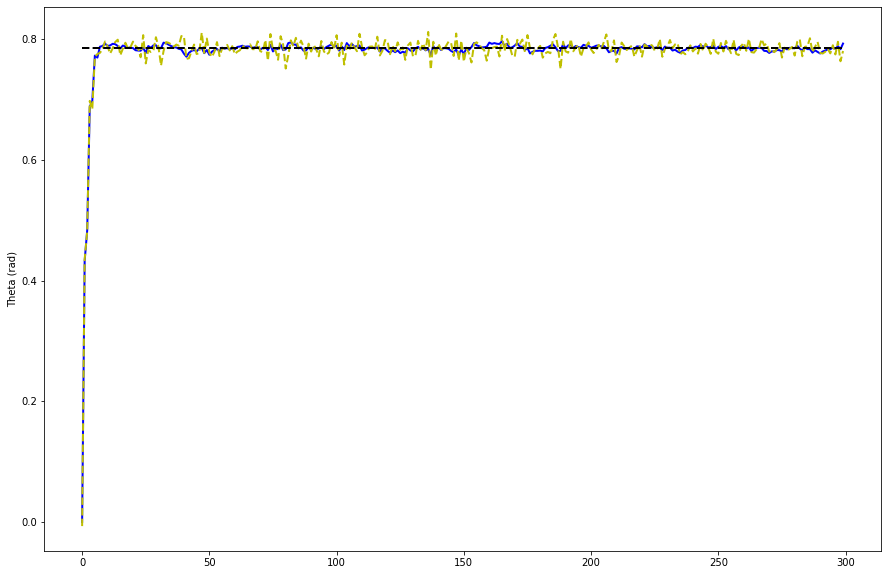

In [17]:
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(ts,theta_store,'b-',linewidth=2)
plt.plot(ts,theta_noisy_store,'y--',linewidth=2)
plt.plot(ts,sp_store,'k--',linewidth=2)
plt.ylabel('Theta (rad)')
plt.show()

In [18]:
possible_angle = [0.262, 0.523, 0.785]

noise = np.random.normal(0.0,0.1, 300)

max_1 = 0
min_1 = 0
max_2 = 0
min_2 = 0
max_3 = 0
min_3 = 0
for i in range(len(possible_angle)):
    sp = np.zeros(300) + possible_angle[i]
    theta_store, omega_store, sp_store, v_store, u_store, ts, theta_noisy_store = pid_model.run(299, 300, sp, [0.0,0.0], noise)
    max_1_t, min_1_t, max_2_t, min_2_t, max_3_t, min_3_t = compute_robustness(ts, theta_store, sp_store)
    max_1 += max_1_t
    min_1 += min_1_t
    max_2 += max_2_t
    min_2 += min_2_t
    max_3 += max_3_t
    min_3 += min_3_t

print(f'max robustness phi_1: {round(max_1/len(possible_angle),3)}')
print(f'min robustness phi_1: {round(min_1/len(possible_angle),3)}')
print(f'max robustness phi_2: {round(max_2/len(possible_angle),3)}')
print(f'min robustness phi_2: {round(min_2/len(possible_angle),3)}')
print(f'max robustness phi_3: {round(max_3/len(possible_angle),3)}')
print(f'min robustness phi_3: {round(min_3/len(possible_angle),3)}')

max robustness phi_1: -0.119
min robustness phi_1: -0.119
max robustness phi_2: -0.136
min robustness phi_2: -0.136
max robustness phi_3: 0.171
min robustness phi_3: -0.016


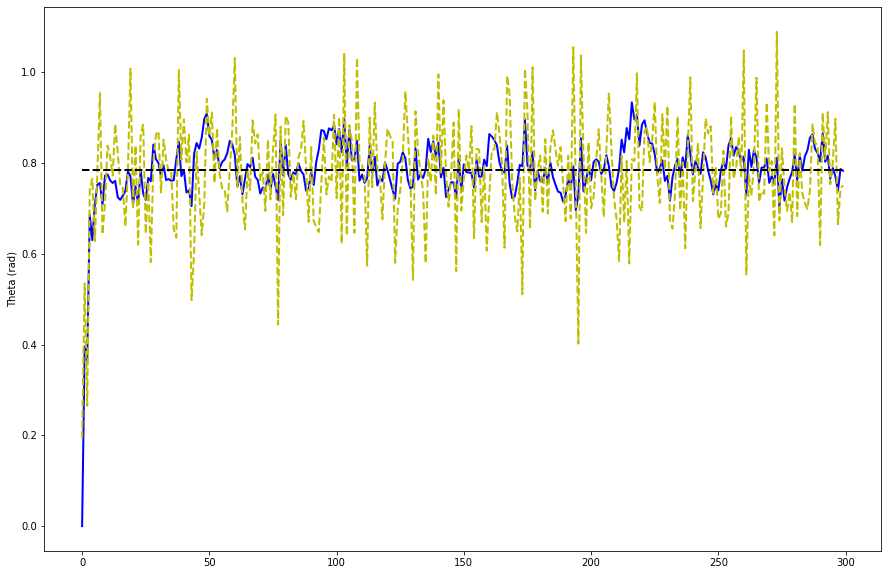

In [19]:
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(ts,theta_store,'b-',linewidth=2)
plt.plot(ts,theta_noisy_store,'y--',linewidth=2)
plt.plot(ts,sp_store,'k--',linewidth=2)
plt.ylabel('Theta (rad)')
plt.show()

## Pid controller with sinusoidal reference signal

overshoot: 0.001
rise time: 5.0
steady state error: 0.006
settling time: 270.0


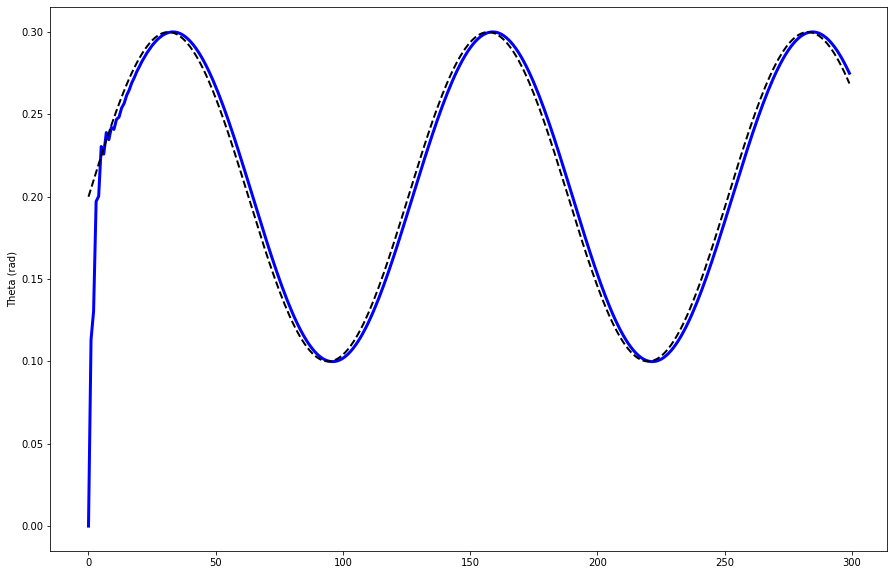

In [20]:
sp = [np.sin(i/20)/10 + 0.2 for i in range(300)]
noise = np.zeros(300)
theta_store, omega_store, sp_store, v_store, u_store, ts, theta_noisy_store = pid_model.run(299, 300, sp, [0.0,0.0], noise)
pidper.print_performances(theta_store, sp_store, ts)
pid_model.plot(theta_store, omega_store, sp_store, v_store,u_store, ts)

In [21]:
max_1, min_1, max_2, min_2, max_3, min_3 = compute_robustness(ts, theta_store, sp_store)
print(f'max robustness phi_1: {round(max_1/len(possible_angle),3)}')
print(f'min robustness phi_1: {round(min_1/len(possible_angle),3)}')
print(f'max robustness phi_2: {round(max_2/len(possible_angle),3)}')
print(f'min robustness phi_2: {round(min_2/len(possible_angle),3)}')
print(f'max robustness phi_3: {round(max_3/len(possible_angle),3)}')
print(f'min robustness phi_3: {round(min_3/len(possible_angle),3)}')

max robustness phi_1: 0.015
min robustness phi_1: 0.015
max robustness phi_2: 0.014
min robustness phi_2: 0.014
max robustness phi_3: 0.055
min robustness phi_3: 0.054
